In [1]:
#------------------- Change working directory to project root -------------------#
from pathlib import Path, os

cur = Path().resolve()
while not (cur / "src").is_dir():
    if cur == cur.parent: raise RuntimeError("No 'src' dir")
    cur = cur.parent

os.chdir(cur)
print(f"[INFO] Changed working directory to project root: {cur}")

[INFO] Changed working directory to project root: /home/fernando/Documents/LoRaPriv


In [2]:
import os
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
import importlib.util

# ── Imports from unified API --------------------------------------------
from src.core.params import LoRaPhyParams, LoRaFrameParams
from src.mod.modulator import LoRaModulator
from src.demod.demodulator import LoRaDemodulator
from src.sync.correlation_based_synchronizer import CorrelationBasedSynchronizer

# ── Modem configuration -------------------------------------------------
sf, bw, spc, psc= 7, 125e3, 5, 8
phy_params = LoRaPhyParams(spreading_factor=sf, bandwidth=bw, samples_per_chip=spc)
frame_params = LoRaFrameParams(preamble_symbol_count=psc,
                               explicit_header=True,  # includes 2-symbol header
                               sync_word=0x00)        # not yet used

sps = spc * (1 << sf)  # Samples per symbol
payload_len = 1000     # Payload length in symbols

def test_lora_sync_quality():
    incorrect_offsets = []
    match_vector = []

    print("\n[INFO] Starting synchronization quality test...\n")

    for unsync_offset in range(0, 2**sf * spc):
        # ── Random payload ------------------------------------------------------
        payload = [random.randint(0, (1 << sf) - 1) for _ in range(payload_len)]

        # ── Modulate full frame -------------------------------------------------
        mod = LoRaModulator(phy_params, frame_params, backend="numpy")
        modulated_frame = mod.modulate(payload, include_frame=True)

        # ── Artificially unsync the signal --------------------------------------
        zero_pad = np.zeros(unsync_offset, dtype=modulated_frame.dtype)
        unsynced = np.concatenate([zero_pad, modulated_frame])
        max_len = (2 ** 20) - 1
        remaining = max_len - len(unsynced)

        if remaining >= 0:
            unsynced = np.concatenate([unsynced, np.zeros(remaining, dtype=unsynced.dtype)])
        else:
            raise ValueError("Frame length exceeds maximum allowed size for the buffer.")

        # ── Synchronize + Extract payload ---------------------------------------
        sync = CorrelationBasedSynchronizer(phy_params, frame_params)
        payload_waveform = sync.run(unsynced)

        # ── Demodulate the extracted payload --------------------------------- ---
        demod = LoRaDemodulator(phy_params,
                                fold_mode="0FPA")
        decoded_syms = demod.demodulate(payload_waveform)

        # ── Verify and visualize ------------------------------------------------
        decoded = decoded_syms.tolist()
        correct = decoded == payload
        match_vector.append(correct)

        if correct:
            print(f"[✓ offset={unsync_offset:>3}] Payload matched", end="\n" if (unsync_offset+1) % 5 == 0 else " | ")
        else:
            incorrect_offsets.append(unsync_offset)
            print(f"\n[✗ offset={unsync_offset:>3}] Payload MISMATCH")
            print(f"  ├─ Original: {payload[:10]}... (len={len(payload)})")
            print(f"  └─ Decoded : {decoded[:10]}... (len={len(decoded)})")
        demod.backend.clear_memory()

    # ── Final Summary -------------------------------------------------------
    print("\n\n[SUMMARY]")
    if incorrect_offsets:
        print(f"❌ Some payloads failed to synchronize.")
        print(f"   Incorrect offsets ({len(incorrect_offsets)}): {incorrect_offsets}")
    else:
        print("✅ All payloads matched successfully!")

    # ── Visualization -------------------------------------------------------
    plt.figure(figsize=(14, 4))
    x = list(range(2**sf * spc))
    y = [1 if m else 0 for m in match_vector]
    colors = ['green' if m else 'red' for m in match_vector]

    plt.scatter(x, y, c=colors, s=20, marker='|')
    plt.yticks([0, 1], ["Mismatch", "Match"])
    plt.title("LoRa Synchronization Test by Unsync Offset")
    plt.xlabel("Unsync Offset (samples)")
    plt.ylabel("Result")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


[WARN - PHY LoRA params] samples_per_chip > 2 is not standard. This may lead to unexpected results in some cases. (FPA and CPA folding may not work as expected)


# Prueba de Sincronización Basada en Correlación para LoRa

## ¿Qué hace esta prueba?

Esta prueba evalúa **cualitativamente** un sincronizador de tramas LoRa basado en correlación cruzada Para cada desplazamiento posible dentro de una duración de símbolo:

1. Se genera un payload aleatorio.
2. Se modula en una trama LoRa completa.
3. Se le aplica un **desfase artificial** (con ceros al inicio), simulando una captura real de un SDR.
4. El sincronizador intenta detectar el **inicio correcto** de la trama en el buffer.
5. Se demodula y se compara contra el payload original.

Al final, se muestra un gráfico que indica qué desplazamientos fueron correctamente sincronizados.

## ¿Por qué es importante?

En escenarios reales con SDRs, los buffers de IQ:

- Contienen datos continuos donde las tramas pueden empezar en cualquier posición.
- Requieren **detectar con precisión el inicio de la trama** antes de demodular.
- Si hay desalineación, la decodificación falla.

Esta prueba garantiza que el sincronizador:

- Funciona correctamente para **todos los desfases posibles** dentro de un símbolo.
- Es confiable para, en principio, operar con **buffers reales de IQ**, como los capturados por radios SDR.




[INFO] Starting synchronization quality test...

[✓ offset=  0] Payload matched | [✓ offset=  1] Payload matched | [✓ offset=  2] Payload matched | [✓ offset=  3] Payload matched | [✓ offset=  4] Payload matched
[✓ offset=  5] Payload matched | [✓ offset=  6] Payload matched | [✓ offset=  7] Payload matched | [✓ offset=  8] Payload matched | [✓ offset=  9] Payload matched
[✓ offset= 10] Payload matched | [✓ offset= 11] Payload matched | [✓ offset= 12] Payload matched | [✓ offset= 13] Payload matched | [✓ offset= 14] Payload matched
[✓ offset= 15] Payload matched | [✓ offset= 16] Payload matched | [✓ offset= 17] Payload matched | [✓ offset= 18] Payload matched | [✓ offset= 19] Payload matched
[✓ offset= 20] Payload matched | [✓ offset= 21] Payload matched | [✓ offset= 22] Payload matched | [✓ offset= 23] Payload matched | [✓ offset= 24] Payload matched
[✓ offset= 25] Payload matched | [✓ offset= 26] Payload matched | [✓ offset= 27] Payload matched | [✓ offset= 28] Payload matched | [✓ 

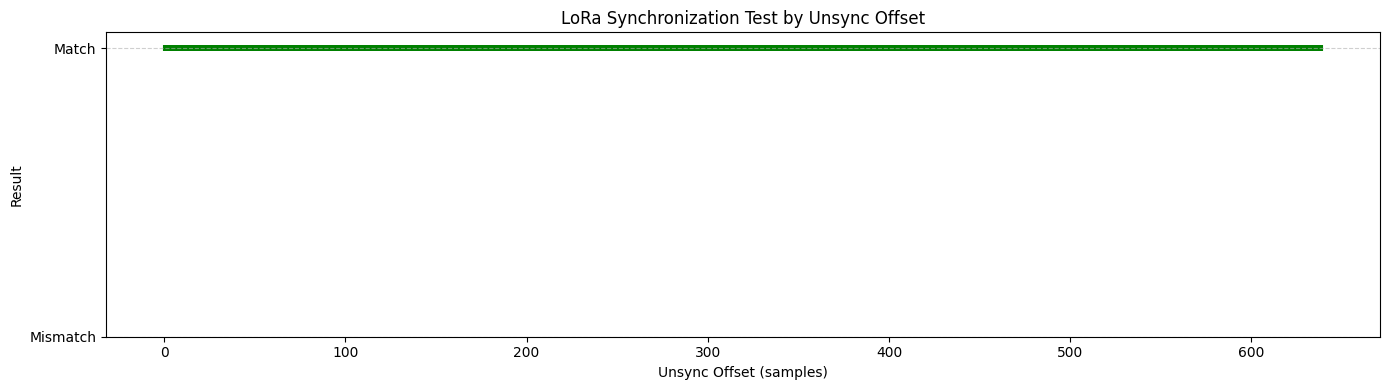

In [3]:
test_lora_sync_quality()